In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pickle

In [3]:
import torch
from collections import Counter
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
#from torchsummary import summary
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
import tqdm
from timeit import default_timer as timer
from torch import Tensor, nn
from torch.nn.functional import interpolate


def load_pickle(name):
    with open(pickle_dir + name + '.pkl', 'rb') as f:
        return pickle.load(f)

x_train = load_pickle('x_train')
x_test = load_pickle('x_test')
x_valid = load_pickle('x_valid')
y_train = load_pickle('y_train')
y_test = load_pickle('y_test')
y_valid = load_pickle('y_valid')

In [4]:
import torchvision.transforms as T
trf = T.Compose([T.Resize(250),
             T.CenterCrop(224),
             T.ToTensor(), 
             T.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225])])
#trf_tab = T.ToTensor() # transforms.Compose([transforms.ToTensor()])
#trf_tab = T.Compose([transforms.ToTensor()])

In [5]:
from ElasticDataset import PickleSeriesDataset

In [6]:
batch_size = 1024

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
print(train_on_gpu,multi_gpu)

Train on gpu: True
1 gpus detected.
True False


In [ ]:
# Dataloader iterators
dataloaders = {
    'train': DataLoader(
        PickleSeriesDataset('X_train', 'y_train', trf), 
        batch_size=batch_size,
        shuffle=False,
        num_workers=5,
    ),
    'val': DataLoader(
        PickleSeriesDataset('X_valid', 'y_valid', trf),
        batch_size=batch_size, 
        shuffle=False,
        num_workers=5,
    ),
    'test': DataLoader(
        PickleSeriesDataset('X_test', 'y_test', trf),
        batch_size=batch_size, 
        shuffle=False,
        num_workers=5,
    )
}

### Model
https://discuss.pytorch.org/t/concatenate-layer-output-with-additional-input-data/20462/2
https://discuss.pytorch.org/t/how-to-combine-tabular-and-image-data/79465/2

In [7]:
import torch.nn.functional as F

In [8]:
class MulticlassClassification(nn.Module):
    def __init__(self, cat_size, num_col, output_size, layers, p=0.4):
        super(MulticlassClassification, self).__init__()
        
        # IMAGE: ResNet
        self.cnn = models.resnet50(pretrained = True)
        for param in self.cnn.parameters():
            param.requires_grad = False
        n_inputs = self.cnn.fc.in_features
        self.cnn.fc = nn.Sequential(
          nn.Linear(n_inputs, 250), 
          nn.ReLU(), 
          nn.Dropout(p),
          nn.Linear(250, output_size),                   
          nn.LogSoftmax(dim=1)
        )
        
        # TABLE: 
        self.all_embeddings = nn.ModuleList(
            [nn.Embedding(categories, size) for categories, size in cat_size]
        )
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_col)

        all_layers = []
        num_cat_col = sum(e.embedding_dim for e in self.all_embeddings)
        input_size = num_cat_col + num_col

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)
        
        #combine
        self.combine_fc = nn.Linear(output_size * 2, output_size)
        #self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, image, x_categorical, x_numerical):
        embeddings = []
        for i, embedding in enumerate(self.all_embeddings):
            print(x_categorical[:,i])
            embeddings.append(embedding(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        
        # img
        x2 = self.cnn(image)
        
        # combine
        x3 = torch.cat([x, x2], 1)
        x3 = F.relu(self.combine_fc(x3))
        #x3 = self.logsoftmax(x3)
        
        return x

In [9]:
pickle_dir = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\'
def load_pickle(name):
    with open(pickle_dir + name + '.pkl', 'rb') as f:
        return pickle.load(f)
categorical_embedding_sizes = load_pickle('categorical_embedding_sizes')

In [10]:
model = MulticlassClassification(categorical_embedding_sizes, 4, 20, [403, 376], p=0.2)
model

MulticlassClassification(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [11]:
from torch import cuda, optim

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
print(train_on_gpu,multi_gpu)

Train on gpu: True
1 gpus detected.
True False


In [12]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

In [13]:
criterion = nn.CrossEntropyLoss() #nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

### Training

In [15]:
#import torch
#import torchvision # torch package for vision related things
#import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
#import torchvision.datasets as datasets  # Standard datasets
#import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
#from torch import optim  # For optimizers like SGD, Adam, etc.
#from torch import nn  # All neural network modules
#from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
#from tqdm import tqdm

In [14]:
save_file_name = 'C:\\NFT_data\\networks\\combined.pt'
checkpoint_path = 'C:\\NFT_data\\networks\\combined.pth'

In [18]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (img, stack_cat, stack_num, target) in enumerate(train_loader):
            #print(data)
            #print(img)

            # Tensors to gpu
            if train_on_gpu:
                img, stack_cat, stack_num, target = img.cuda(), stack_cat.cuda(), stack_num.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(img, stack_cat, stack_num)
            
            #output = torch.cat((output_img, output_tab), dim=1)
            #output = self.relu(output)
            #m = nn.Softmax(dim=1)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * img.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * stack_cat.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for ii, (img, stack_cat, stack_num, target) in enumerate(valid_loader):
                    # Tensors to gpu
                    if train_on_gpu:
                        img, stack_cat, stack_num, target = img.cuda(), stack_cat.cuda(), stack_num.cuda(), target.cuda()

                    # Forward pass
                    output = model(img, stack_cat, stack_num)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * img.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * img.size(0)
                    
                    # Track validation progress
                    print(
                        f'Epoch: {epoch}\t{100 * (ii + 1) / len(valid_loader):.2f}% validated. {timer() - start:.2f} seconds elapsed in epoch.',
                        end='\r')

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    valid_acc = history[best_epoch][3]
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [17]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=50,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	101.42% validated. 3213.26 seconds elapsed in epoch.
Epoch: 0 	Training Loss: -208.4527 	Validation Loss: -537.9617
		Training Accuracy: 50.27%	 Validation Accuracy: 61.43%
Epoch: 1	101.42% validated. 4013.81 seconds elapsed in epoch.
Epoch: 1 	Training Loss: -1080.0910 	Validation Loss: -1715.1356
		Training Accuracy: 60.87%	 Validation Accuracy: 54.15%
Epoch: 2	101.42% validated. 4023.61 seconds elapsed in epoch.
Epoch: 2 	Training Loss: -2562.4373 	Validation Loss: -3448.0430
		Training Accuracy: 59.69%	 Validation Accuracy: 52.87%
Epoch: 3	101.42% validated. 3965.60 seconds elapsed in epoch.
Epoch: 3 	Training Loss: -4593.5258 	Validation Loss: -5669.3571
		Training Accuracy: 57.67%	 Validation Accuracy: 51.47%


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 9	101.42% validated. 3880.54 seconds elapsed in epoch.
Epoch: 9 	Training Loss: -25780.4248 	Validation Loss: -27155.4709
		Training Accuracy: 54.05%	 Validation Accuracy: 45.57%
Epoch: 10	101.42% validated. 4038.72 seconds elapsed in epoch.
Epoch: 10 	Training Loss: -30608.1105 	Validation Loss: -31898.6245
		Training Accuracy: 53.83%	 Validation Accuracy: 45.03%
Epoch: 11	101.42% validated. 4193.71 seconds elapsed in epoch.
Epoch: 11 	Training Loss: -35782.2595 	Validation Loss: -36898.8316
		Training Accuracy: 53.67%	 Validation Accuracy: 44.42%


KeyboardInterrupt: 

Because of the missing LogSoftmax function the results were actually getting worse:
Epoch 0:
        Training Loss: -208.4527 	Validation Loss: -537.9617
		Training Accuracy: 50.27%	 Validation Accuracy: 61.43%
        
Epoch 11:
        Training Loss: -35782.2595 	Validation Loss: -36898.8316
		Training Accuracy: 53.67%	 Validation Accuracy: 44.42%

Moved the data to my SSD from the HDD to increase performance

In [19]:
#CrossEntropyLoss
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=50,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	101.42% validated. 1658.43 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.8122 	Validation Loss: 1.5363
		Training Accuracy: 35.51%	 Validation Accuracy: 41.53%
Epoch: 1	101.42% validated. 1589.91 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.5787 	Validation Loss: 1.4785
		Training Accuracy: 40.25%	 Validation Accuracy: 43.54%
Epoch: 2	101.42% validated. 1606.87 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.5279 	Validation Loss: 1.4487
		Training Accuracy: 41.83%	 Validation Accuracy: 44.46%
Epoch: 3	101.42% validated. 1642.08 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.4992 	Validation Loss: 1.4288
		Training Accuracy: 42.75%	 Validation Accuracy: 45.26%
Epoch: 4	101.42% validated. 1593.90 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.4764 	Validation Loss: 1.4144
		Training Accuracy: 43.53%	 Validation Accuracy: 45.83%
Epoch: 5	101.42% validated. 1571.44 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 

Text(0.5, 1.0, 'Training and Validation Losses')

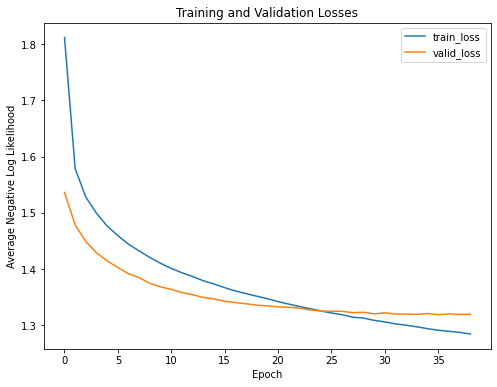

In [20]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

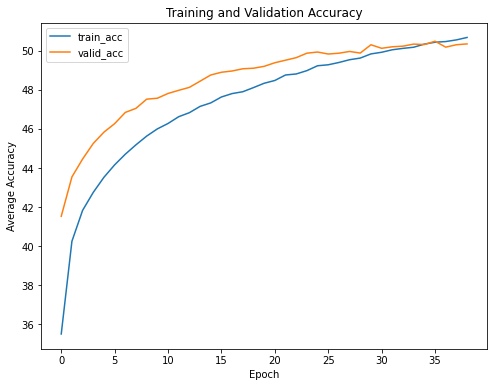

In [21]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [20]:
model.idx_to_class = ['0.0-1.0',
 '1.0-1.7',
 '1.7-3.0',
 '3.0-5.3',
 '5.3-9.1',
 '9.1-15.9',
 '15.9-27.7',
 '27.7-48.1',
 '48.1-83.7',
 '83.7-145.5',
 '145.5-253.0',
 '253.0-440.1',
 '440.1-765.3',
 '765.3-1331.0',
 '1331.0-2314.6',
 '2314.6-4025.3',
 '4025.3-7000.4',
 '7000.4-12174.3',
 '12174.3-21172.1',
 '21172.1-36820.0']

In [21]:
model.class_to_idx = {'0.0-1.0': 0,
 '1.0-1.7': 1,
 '1.7-3.0': 2,
 '3.0-5.3': 3,
 '5.3-9.1': 4,
 '9.1-15.9': 5,
 '15.9-27.7': 6,
 '27.7-48.1': 7,
 '48.1-83.7': 8,
 '83.7-145.5': 9,
 '145.5-253.0': 10,
 '253.0-440.1': 11,
 '440.1-765.3': 12,
 '765.3-1331.0': 13,
 '1331.0-2314.6': 14,
 '2314.6-4025.3': 15,
 '4025.3-7000.4': 16,
 '7000.4-12174.3': 17,
 '12174.3-21172.1': 18,
 '21172.1-36820.0': 19}

In [24]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if multi_gpu:
        checkpoint['state_dict'] = model.module.state_dict()
    else:
        checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [25]:
save_checkpoint(model, path=checkpoint_path)

In [15]:
def load_checkpoint(model, path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Load in checkpoint
    checkpoint = torch.load(path)

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)
    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [16]:
model, optimizer = load_checkpoint(model, checkpoint_path)

25,323,638 total parameters.
1,815,606 total gradient parameters.


In [23]:
testloader = dataloaders['test']

In [20]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

testiter = iter(testloader)
# Get a batch of testing images and labels
img, stack_cat, stack_num, target = next(testiter)

if train_on_gpu:
    res = accuracy(model(img.cuda(), stack_cat.cuda(), stack_num.cuda()), target, topk=(1, ))
else:
    res = accuracy(model(img.cuda(), stack_cat.cuda(), stack_num.cuda()), target, topk=(1, 5))
print(res)

[51.171875]


In [29]:
def evaluate(model, test_loader, criterion, topk=(1, 3, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """
    confusion_matrix = torch.zeros(20, 20)
    classes = []
    losses = []
    estimated_len = len(test_loader.dataset)
    # Hold accuracy results
    acc_results = np.zeros((estimated_len, len(topk)))
    i = 0
    start = timer()
    
    print(f'Starting Evaluatation.\n')

    model.eval()
    with torch.no_grad():

        # Testing loop      
        for img, stack_cat, stack_num, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                img, stack_cat, stack_num, targets = img.cuda(), stack_cat.cuda(), stack_num.cuda(), targets.cuda()
        
            # Raw model output
            out = model(img, stack_cat, stack_num)
            _, predscm = torch.max(out, 1)
            for t, p in zip(targets.view(-1), predscm.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, 20), true.view(1))
                losses.append(loss.item())
                i += 1
            
                # Track progress
                print(
                    f'i: {i} / {estimated_len} evaluated. {timer() - start:.2f} seconds elapsed.',
                    end='\r')

    # Send results to a dataframe and calculate average across classes
    diff_len =  estimated_len - i
    acc_results = acc_results[:-diff_len]
    print(f'\n{len(acc_results)}')
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'}), confusion_matrix

criterion = nn.CrossEntropyLoss()
# Evaluate the model on all the training data
results,confusion_matrix = evaluate(model, dataloaders['test'], criterion)

Starting Evaluatation.

i: 287110 / 287199 evaluated. 811.08 seconds elapsed.
287110


In [30]:
results

,class,top1,top3,top5,loss
0,0.0-1.0,54.993835,66.214550,73.890259,1.862551
1,1.0-1.7,9.523810,22.222222,30.158730,4.670896
2,1.7-3.0,12.903226,20.737327,25.806452,4.056440
3,12174.3-21172.1,42.657875,84.808521,93.558204,1.435299
4,1331.0-2314.6,43.823290,83.271909,95.419518,1.488716
5,145.5-253.0,57.210645,92.103942,98.240020,1.159426
6,15.9-27.7,32.897941,65.884437,77.529334,2.039527
7,21172.1-36820.0,56.607930,86.167401,92.687225,1.276230
8,2314.6-4025.3,54.641278,82.522951,93.689221,1.388117
9,253.0-440.1,55.415865,93.537108,98.510981,1.117643


In [32]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'outputs/confusion_matrix.png')
    return plt

In [34]:
classnames = [model.idx_to_class[i] for i in range(0, 20)]

Confusion matrix, without normalization


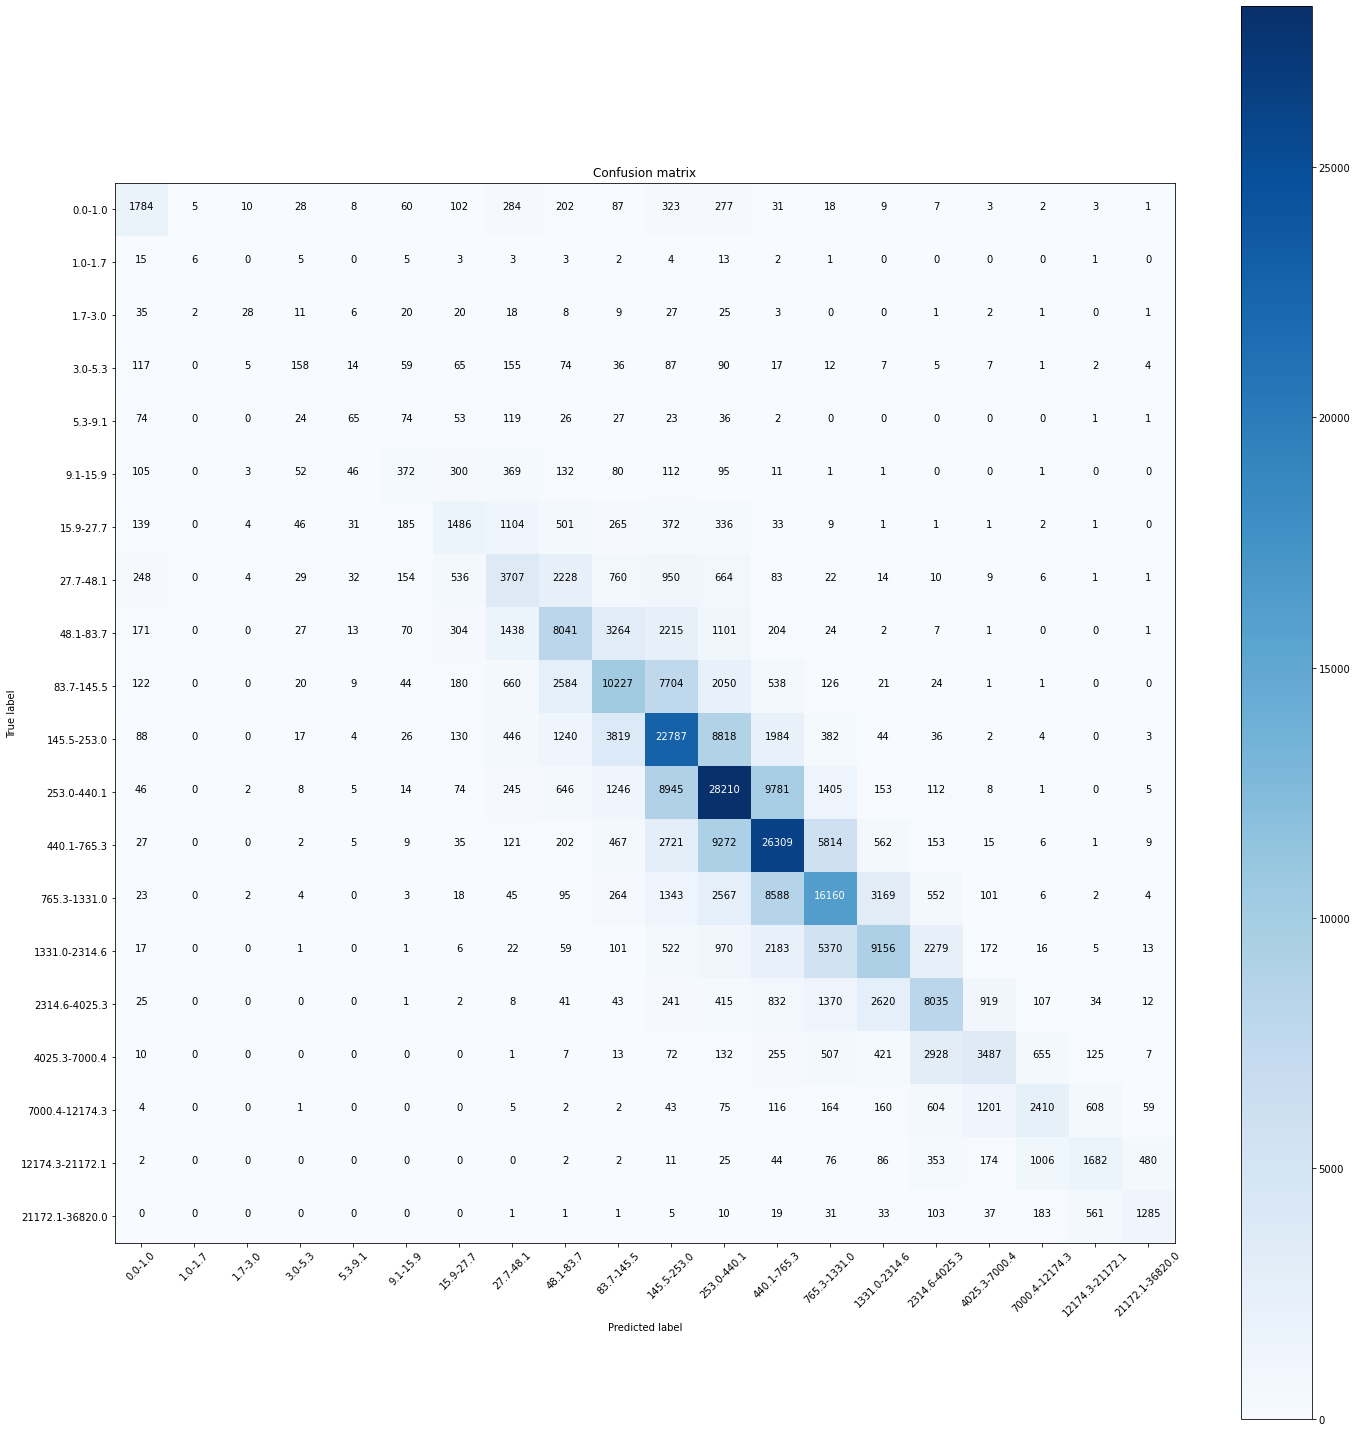

In [35]:
plt.figure(figsize=(20,20))
plt = plot_confusion_matrix(confusion_matrix, classnames)

In [36]:
def cm_as_dataframe(cm):
    cm = pd.DataFrame(cm)
    cm.columns = classnames
    cm.index = classnames
    cm = cm.reset_index()
    return cm

cm_as_dataframe(confusion_matrix.cpu().numpy()).to_csv(f'outputs/confmat.csv',index=None)

In [37]:
print(f"Overall Accuracy:{confusion_matrix.diag().sum()/confusion_matrix.sum()}")

Overall Accuracy:0.50640869140625


## Captum

In [17]:
# Initial imports
import numpy as np

import torch

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

In [18]:
ig = IntegratedGradients(model)

In [19]:
testloader = DataLoader(
        PickleSeriesDataset('X_test', 'y_test', trf),
        batch_size=1, 
        shuffle=False,
        num_workers=1,
    )

LOADING: D:\Code\datascience\MA_NFT\data\pickle\X_test.pkl
LOADING: D:\Code\datascience\MA_NFT\data\pickle\y_test.pkl


In [20]:
model.eval()

MulticlassClassification(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [22]:
testiter = iter(testloader)
# Get a batch of testing images and labels
img, stack_cat, stack_num, target = next(testiter)

attributions_ig = ig.attribute(inputs=(img.cuda(), stack_cat.cuda(), stack_num.cuda()), target=target.cuda())

tensor([2.0405e-02, 1.0742e-01, 2.6363e-01, 4.8844e-01, 7.8100e-01, 1.1402e+00,
        1.5646e+00, 2.0526e+00, 2.6023e+00, 3.2115e+00, 3.8780e+00, 4.5991e+00,
        5.3721e+00, 6.1939e+00, 7.0613e+00, 7.9712e+00, 8.9198e+00, 9.9035e+00,
        1.0919e+01, 1.1961e+01, 1.3027e+01, 1.4112e+01, 1.5212e+01, 1.6323e+01,
        1.7440e+01, 1.8560e+01, 1.9677e+01, 2.0788e+01, 2.1888e+01, 2.2973e+01,
        2.4039e+01, 2.5081e+01, 2.6097e+01, 2.7080e+01, 2.8029e+01, 2.8939e+01,
        2.9806e+01, 3.0628e+01, 3.1401e+01, 3.2122e+01, 3.2788e+01, 3.3398e+01,
        3.3947e+01, 3.4435e+01, 3.4860e+01, 3.5219e+01, 3.5512e+01, 3.5736e+01,
        3.5893e+01, 3.5980e+01], device='cuda:0', grad_fn=<SelectBackward>)


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [29]:
model(img.cuda(), stack_cat.cuda(), stack_num.cuda())

tensor([36], device='cuda:0')
tensor([0], device='cuda:0')
tensor([4095], device='cuda:0')
tensor([36], device='cuda:0')
tensor([2], device='cuda:0')
tensor([14], device='cuda:0')
tensor([12], device='cuda:0')
tensor([10], device='cuda:0')
tensor([2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')


tensor([[ -5.7880, -12.0875, -14.3919,  -8.3743,  -9.9950, -10.0665,  -9.1387,
          -5.5033,  -2.5973,  -0.7712,   0.9523,   1.9533,   3.5334,   2.5602,
           0.1857,  -0.6805,  -2.5112,  -3.3944,  -4.9417,  -7.4695]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [27]:
stack_cat[:,3]

tensor([36])

In [52]:
categorical_embedding_sizes

[(4096, 50),
 (2, 1),
 (4096, 50),
 (4096, 50),
 (3, 2),
 (30, 15),
 (4096, 50),
 (4096, 50),
 (4, 2),
 (2, 1),
 (2, 1),
 (2, 1)]